# Tutorial 04

- Model
  - simple FFN
  - high level pytorch utilities/layers

- Data
  - use embeddings
  
  - [sentiment classification (pos vs neg vs neutral)](https://huggingface.co/datasets/syedkhalid076/Sentiment-Analysis)
  



In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


- after completion, restart the runtime
- Runtime -> Restart Session
- continue to the next cell

In [ ]:
!pip install gensim compress_fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

### Imports

In [ ]:
import numpy as np
import pandas as pd
import string
from gensim.models import KeyedVectors
import spacy
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import compress_fasttext

### Train Dataset

- change all of the paths with your paths to the dataset !



In [ ]:
df_train = pd.read_csv('drive/MyDrive/Experiments/SNLP2/week_04/Sentiment-Analysis/train_data.csv', delimiter=',')[: 8000]
df_train = df_train[df_train['label'] != 1]
df_train['label'] = np.where(df_train['label'] == 2, 1, 0)
df_train

,text,label
0,almost got in a giant car accident on the 101,0
1,like something wholly original,1
2,b.s. one another,0
3,"Happy Star Wars Day, may the 4th be with you ...",1
4,few new converts,0
...,...,...
7995,seem goofy rather than provocative,0
7996,I had to get a refund because this is not B-Re...,0
7997,moonlight mile does n't quite go the distance ...,1
7998,"'s a work that , with humor , warmth , and int...",1


In [ ]:
df_val = pd.read_csv('drive/MyDrive/Experiments/SNLP2/week_04/Sentiment-Analysis/val_data.csv', delimiter=',')[: 2000]
df_val = df_val[df_val['label'] != 1]
df_val['label'] = np.where(df_val['label'] == 2, 1, 0)
df_val

,text,label
0,WOOOOOOOOOO are you coming to Nottingham at...,1
1,"and thanks, , fr. yr congratulatory gweetin`",1
2,wonderous accomplishment,1
3,the pungent bite of its title,0
4,sketchy characters and immature provocations,0
...,...,...
1995,super-stupid,0
1996,it 's easier to change the sheets than to chan...,0
1997,wreaked,0
1998,look ahead and resist living in a past,1


In [ ]:
df_test = pd.read_csv('drive/MyDrive/Experiments/SNLP2/week_04/Sentiment-Analysis/test_data.csv', delimiter=',')[: 1000]
df_test = df_test[df_test['label'] != 1]
df_test['label'] = np.where(df_test['label'] == 2, 1, 0)
df_test

,text,label
0,find a spark of its own,1
1,oh come on .,0
2,winningly,1
3,an old-fashioned but emotionally stirring adve...,1
4,"salt and vinegar, cheese and onion make your ...",0
...,...,...
994,"an empty exercise , a florid but ultimately va...",0
995,new adaptation,1
996,http://yfrog.com/0guyoj bonfires are my fave!,1
997,can usually be traced back to the little things,1


### Labels

In [ ]:
Y_train = list(df_train['label'])
Y_val = list(df_val['label'])
Y_test = list(df_test['label'])
# positive, negative
print(Y_train.count(0), Y_train.count(1))
print(Y_val.count(0), Y_val.count(1))
print(Y_test.count(0), Y_test.count(1))

3177 3881
794 927
399 493


### Embeddings Matrix

- because of our limited time, we will use the compressed FastText model instead (uploaded on GitHub)
- you can download GoogleNewsvectorsnegative300  on your own but it will take longer


In [ ]:
# fasttext
# embeddings = compress_fasttext.models.CompressedFastTextKeyedVectors.load("drive/MyDrive/Experiments/SNLP2/week_04/models/cc.en.300.compressed.bin")

# word2vec
embeddings = KeyedVectors.load_word2vec_format("drive/MyDrive/Experiments/SNLP2/week_04/models/GoogleNewsvectorsnegative300.bin", binary=True, limit=100000)

- if you are using FastText model, it is based on ngrams and therefore it will not have OOV words
- you will not need the if-else condition

In [ ]:
vocab = {'<UNK>': 0, '<PAD>': 1}

for i, w in enumerate(embeddings.index_to_key):
    vocab[w] = i + 2

emb = np.zeros((len(vocab), 300))
for w, i in vocab.items():
    if w == '<UNK>' or w == '<PAD>':
        emb[i] = np.random.normal(scale=0.6, size=(300,))
    else:
        emb[i] = embeddings[w]
emb = torch.tensor(emb, dtype=torch.float32)

print(emb.shape)

torch.Size([100002, 300])


### Dataset, DataLoader

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx].lower().strip(string.punctuation).strip().split(' ')
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(self.labels[idx], dtype=torch.long)


train_dataset = SentimentDataset(texts=list(df_train['text']), labels=list(df_train['label']), vocab=vocab, max_len=30)
train_loader = DataLoader(train_dataset, batch_size=8)

val_dataset = SentimentDataset(texts=list(df_val['text']), labels=list(df_val['label']), vocab=vocab, max_len=30)
val_loader = DataLoader(val_dataset, batch_size=8)

test_dataset = SentimentDataset(texts=list(df_test['text']), labels=list(df_test['label']), vocab=vocab, max_len=30)
test_loader = DataLoader(test_dataset, batch_size=8)

### Feed-Forward Network

In [ ]:
class FFN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, emb_matrix):
        super(FFN, self).__init__()
        self.embedding = nn.Embedding(in_feats, emb_matrix.shape[1])
        self.embedding.weight = nn.Parameter(emb_matrix, requires_grad=True)
        self.lin1 = nn.Linear(emb_matrix.shape[1], hidden_size)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_size, out_feats)

    def forward(self, X):
        e = self.embedding(X)
        e = e.mean(dim=1)

        input = self.lin1(e)
        hidden = self.relu(input)
        out = self.lin2(hidden)

        return out


### Trainer

In [ ]:

def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return precision, recall, f1


device = 'cuda' if torch.cuda.is_available() else 'cpu'

### hyperparameters
in_feats = len(vocab)
hidden_size = in_feats * 8
out_classes = 1
epochs = 50
early_stopping = 50
lr = 1e-5
model_name = 'best-model-bin'

### neural net
ffn = FFN(in_feats=in_feats, hidden_size=hidden_size, out_feats=out_classes, emb_matrix=emb).to(device)

### optimizer - AdamW = architectural variant of Gradient Descent
opt = torch.optim.AdamW(ffn.parameters(), lr=lr)

### loss function
### 1. Binary Classification - BCELoss(), BCEWithLogitsLoss
### difference - needs sigmoid/internal sigmoid

### 2. Multi Class Classification - NLLLoss(), CrossEntropyLoss()
### difference - needs softmax/internal softmax


loss_fn = torch.nn.BCEWithLogitsLoss()

best_f1, best_model_dict, bestloss = 0.0, None, 0.0
tolerance = early_stopping

for epoch in tqdm(range(epochs), desc='Training Started'):
    epoch_loss = []
    for examples, y in train_loader:
        # BCE
        y = y.float().unsqueeze(1).to(device)
        opt.zero_grad()

        y_hat = ffn(examples.to(device))
        loss = loss_fn(y_hat, y)

        epoch_loss.append(loss.item())
        loss.backward()

        opt.step()

    ### evaluation every epoch
    ### on dev set
    y_true, y_pred = [], []
    for examples_val, y_val in val_loader:
        y_hat_val = ffn(examples_val.to(device))
        y_true.extend([_.item() for _ in y_val])
        y_pred.extend([1 if _.item() >= .5 else 0 for _ in torch.sigmoid(y_hat_val).squeeze(1)])

    p, r, f1 = compute_metrics(y_true, y_pred)

    if best_f1 < f1:
        best_f1 = f1
        best_model_dict = deepcopy(ffn.state_dict())
        tolerance = early_stopping
        bestloss = sum(epoch_loss) / len(epoch_loss)
    else:
        tolerance -= 1
        if tolerance == 0:
            print(f'no improvement for {early_stopping} epochs')
            break

    print(f'epoch: {epoch + 1} '
          f'loss: {sum(epoch_loss) / len(epoch_loss)}\n'
          f'metrics: {p, r, f1}')



Training Started:   2%|▏         | 1/50 [00:18<15:20, 18.78s/it]

epoch: 1 loss: 0.7148340472346119
metrics: (0.6968939777327935, 0.5253723313198503, 0.41070758809419394)


Training Started:   4%|▍         | 2/50 [00:37<15:01, 18.78s/it]

epoch: 2 loss: 0.684401492469038
metrics: (0.6778601353528844, 0.5449895249973506, 0.4577339721889485)


Training Started:   6%|▌         | 3/50 [00:56<14:42, 18.77s/it]

epoch: 3 loss: 0.6558198259546425
metrics: (0.7107779369911318, 0.5867346522869743, 0.5322171492813927)


Training Started:   8%|▊         | 4/50 [01:15<14:23, 18.78s/it]

epoch: 4 loss: 0.626803528850778
metrics: (0.7208271696555384, 0.6220949190123336, 0.589868890367692)


Training Started:  10%|█         | 5/50 [01:33<14:04, 18.77s/it]

epoch: 5 loss: 0.5982809396521827
metrics: (0.732656498412259, 0.650706213537888, 0.630948476846366)


Training Started:  12%|█▏        | 6/50 [01:52<13:46, 18.78s/it]

epoch: 6 loss: 0.5711914779004532
metrics: (0.7460450197605819, 0.6750874275512949, 0.6627149222959239)


Training Started:  14%|█▍        | 7/50 [02:11<13:27, 18.77s/it]

epoch: 7 loss: 0.5460472271808277
metrics: (0.7521702399345312, 0.6942528782481339, 0.6871542121975319)


Training Started:  16%|█▌        | 8/50 [02:30<13:08, 18.78s/it]

epoch: 8 loss: 0.5230159573552292
metrics: (0.758083182454119, 0.7045091421910281, 0.699330875801464)


Training Started:  18%|█▊        | 9/50 [02:49<12:50, 18.78s/it]

epoch: 9 loss: 0.5021212915568227
metrics: (0.7704927401759569, 0.7186313750105293, 0.715154662734953)


Training Started:  20%|██        | 10/50 [03:07<12:31, 18.78s/it]

epoch: 10 loss: 0.48319149199590544
metrics: (0.7726512757471088, 0.7217799896201011, 0.7187249601531969)


Training Started:  22%|██▏       | 11/50 [03:26<12:12, 18.78s/it]

epoch: 11 loss: 0.46604269696557776
metrics: (0.776380766731644, 0.7253776299593228, 0.722636014107308)


Training Started:  24%|██▍       | 12/50 [03:45<11:53, 18.78s/it]

epoch: 12 loss: 0.450463957924265
metrics: (0.778088993517797, 0.7278965216469802, 0.7254719813834778)


Training Started:  26%|██▌       | 13/50 [04:04<11:35, 18.79s/it]

epoch: 13 loss: 0.43626664837111434
metrics: (0.7789423286828474, 0.7291559674908089, 0.7268860888056623)


Training Started:  28%|██▊       | 14/50 [04:22<11:16, 18.79s/it]

epoch: 14 loss: 0.42322875377073427
metrics: (0.7799405560247048, 0.729695341816591, 0.727421173304182)


Training Started:  30%|███       | 15/50 [04:41<10:57, 18.78s/it]

epoch: 15 loss: 0.4111916107945102
metrics: (0.7832116136458354, 0.7326632592338982, 0.7306103694128577)


Training Started:  32%|███▏      | 16/50 [05:00<10:38, 18.79s/it]

epoch: 16 loss: 0.4000164142230764
metrics: (0.7832116136458354, 0.7326632592338982, 0.7306103694128577)


Training Started:  34%|███▍      | 17/50 [05:19<10:19, 18.78s/it]

epoch: 17 loss: 0.3895769829472626
metrics: (0.788872485236713, 0.7352697822666765, 0.7331230297595099)


Training Started:  36%|███▌      | 18/50 [05:38<10:01, 18.78s/it]

epoch: 18 loss: 0.37977978587994354
metrics: (0.787226711823486, 0.732750890579019, 0.7302883719246813)


Training Started:  38%|███▊      | 19/50 [05:56<09:42, 18.78s/it]

epoch: 19 loss: 0.37053616543217127
metrics: (0.7849569184324563, 0.7303223474874938, 0.7276205418275152)


Training Started:  40%|████      | 20/50 [06:15<09:23, 18.78s/it]

epoch: 20 loss: 0.3617919578321388
metrics: (0.7868150684931507, 0.7321211676571047, 0.7295780787478204)


Training Started:  42%|████▏     | 21/50 [06:34<09:04, 18.78s/it]

epoch: 21 loss: 0.35347930871853067
metrics: (0.7897042035992479, 0.7344593621524975, 0.7320704466856285)


Training Started:  44%|████▍     | 22/50 [06:53<08:45, 18.78s/it]

epoch: 22 loss: 0.34556088972064675
metrics: (0.7897042035992479, 0.7344593621524975, 0.7320704466856285)


Training Started:  46%|████▌     | 23/50 [07:11<08:27, 18.78s/it]

epoch: 23 loss: 0.3379949203239899
metrics: (0.791554892361344, 0.7362581823221084, 0.7340257155007827)


Training Started:  48%|████▊     | 24/50 [07:30<08:08, 18.78s/it]

epoch: 24 loss: 0.330760000608988
metrics: (0.7929976192072966, 0.7374272795698048, 0.7352714966928164)


Training Started:  50%|█████     | 25/50 [07:49<07:49, 18.78s/it]

epoch: 25 loss: 0.3238301548604787
metrics: (0.7944403460532493, 0.7385963768175012, 0.7365172778848503)


Training Started:  52%|█████▏    | 26/50 [08:08<07:30, 18.78s/it]

epoch: 26 loss: 0.3171817814068508
metrics: (0.7944403460532493, 0.7385963768175012, 0.7365172778848503)


Training Started:  54%|█████▍    | 27/50 [08:27<07:12, 18.78s/it]

epoch: 27 loss: 0.31079989961967597
metrics: (0.7958830728992019, 0.7397654740651978, 0.7377630590768841)


Training Started:  56%|█████▌    | 28/50 [08:45<06:53, 18.78s/it]

epoch: 28 loss: 0.3046624573498188
metrics: (0.7936354253863558, 0.7373369309736726, 0.7351000692830526)


Training Started:  58%|█████▊    | 29/50 [09:04<06:34, 18.78s/it]

epoch: 29 loss: 0.2987552938955422
metrics: (0.7934018533216789, 0.7380570024917192, 0.7359795297516187)


Training Started:  60%|██████    | 30/50 [09:23<06:15, 18.78s/it]

epoch: 30 loss: 0.2930702882400152
metrics: (0.7946143195542654, 0.7399461712574622, 0.7380997564772813)


Training Started:  62%|██████▏   | 31/50 [09:42<05:56, 18.78s/it]

epoch: 31 loss: 0.2876032861213317
metrics: (0.7946143195542654, 0.7399461712574622, 0.7380997564772813)


Training Started:  64%|██████▍   | 32/50 [10:01<05:38, 18.78s/it]

epoch: 32 loss: 0.2823340369858869
metrics: (0.7954224754475354, 0.741205617101291, 0.7395100354340536)


Training Started:  66%|██████▌   | 33/50 [10:19<05:19, 18.78s/it]

epoch: 33 loss: 0.27724849138227486
metrics: (0.7978465619652331, 0.7449839546327771, 0.743725673656068)


Training Started:  68%|██████▊   | 34/50 [10:38<05:00, 18.78s/it]

epoch: 34 loss: 0.2723549318247784
metrics: (0.7994626254257572, 0.7475028463204345, 0.7465236027700985)


Training Started:  70%|███████   | 35/50 [10:57<04:41, 18.78s/it]

epoch: 35 loss: 0.26762861311899777
metrics: (0.8006748566748567, 0.7493920150861776, 0.7486155843183984)


Training Started:  72%|███████▏  | 36/50 [11:16<04:22, 18.78s/it]

epoch: 36 loss: 0.2630883151726504
metrics: (0.801700580686088, 0.7520012553699673, 0.7515470803706098)


Training Started:  74%|███████▍  | 37/50 [11:34<04:04, 18.78s/it]

epoch: 37 loss: 0.25870664589031095
metrics: (0.8023394413805373, 0.7539807727318426, 0.753771265981422)


Training Started:  76%|███████▌  | 38/50 [11:53<03:45, 18.78s/it]

epoch: 38 loss: 0.2544636581692157
metrics: (0.8031552160386248, 0.7552402185756714, 0.75515123931846)


Training Started:  78%|███████▊  | 39/50 [12:12<03:26, 18.79s/it]

epoch: 39 loss: 0.2503865621150772
metrics: (0.8065767049557573, 0.7595579304329396, 0.7598226554448644)


Training Started:  80%|████████  | 40/50 [12:31<03:07, 18.79s/it]

epoch: 40 loss: 0.24643276040974924
metrics: (0.8069835438046415, 0.7601876533548539, 0.760508511016582)


Training Started:  82%|████████▏ | 41/50 [12:50<02:49, 18.79s/it]

epoch: 41 loss: 0.24261176415496544
metrics: (0.8064211452335253, 0.7602780019509863, 0.760647907315146)


Training Started:  84%|████████▍ | 42/50 [13:08<02:30, 18.79s/it]

epoch: 42 loss: 0.23892744578893632
metrics: (0.807376075281593, 0.7636073137528225, 0.7643333361861644)


Training Started:  86%|████████▌ | 43/50 [13:27<02:11, 18.78s/it]

epoch: 43 loss: 0.23535924317422802
metrics: (0.8103841869945634, 0.7672953026881764, 0.7682767493816325)


Training Started:  88%|████████▊ | 44/50 [13:46<01:52, 18.79s/it]

epoch: 44 loss: 0.23189944596613082
metrics: (0.8107957321397614, 0.7679250256100908, 0.7689543785879593)


Training Started:  90%|█████████ | 45/50 [14:05<01:33, 18.78s/it]

epoch: 45 loss: 0.22854834493241216
metrics: (0.8110926419483344, 0.7692748200500518, 0.7704351407908876)


Training Started:  92%|█████████▏| 46/50 [14:23<01:15, 18.79s/it]

epoch: 46 loss: 0.22529996277728578
metrics: (0.812747985629731, 0.7717937117377092, 0.7731330290631879)


Training Started:  94%|█████████▍| 47/50 [14:42<00:56, 18.78s/it]

epoch: 47 loss: 0.2221454406422927
metrics: (0.8130658477867507, 0.7731435061776701, 0.774600781347329)


Training Started:  96%|█████████▌| 48/50 [15:01<00:37, 18.79s/it]

epoch: 48 loss: 0.21908739387845602
metrics: (0.8138983693591202, 0.7744029520214989, 0.7759430172223272)


Training Started:  98%|█████████▊| 49/50 [15:20<00:18, 18.78s/it]

epoch: 49 loss: 0.2161164978088754
metrics: (0.8124109529769907, 0.7746739978098958, 0.7763001171967556)


Training Started: 100%|██████████| 50/50 [15:39<00:00, 18.78s/it]

epoch: 50 loss: 0.21320929217636417
metrics: (0.811447938444296, 0.7748546950021602, 0.7765343896530483)


### Save

In [ ]:
torch.save({'state_dict': best_model_dict, 'embeddings': deepcopy(emb), 'epochs': epochs,
            'early_stopping': early_stopping, 'loss': bestloss,
            'loss_fn': loss_fn.__class__.__name__,
            'optimizer': opt.__class__.__name__,
            'in_feats': in_feats, 'hidden_size': hidden_size, 'out_feats': out_classes, 'lr': lr, 'test_loader': deepcopy(test_loader)},
           f'drive/MyDrive/Experiments/SNLP2/week_04/models/{model_name}.pt')

### Evaluate

In [ ]:
ffn.load_state_dict(torch.load('drive/MyDrive/Experiments/SNLP2/week_04/models/best-model-bin.pt', weights_only=False, map_location=device)['state_dict'])

with torch.no_grad():
  y_true, y_pred = [], []
  for examples_test, y_test in test_loader:
      y_hat = ffn.forward(examples_test.to(device))
      y_true.extend([_.item() for _ in y_test])
      y_pred.extend([1 if _.item() >= .5 else 0 for _ in torch.sigmoid(y_hat).squeeze(1)])

compute_metrics(y_true, y_pred)

(0.8149681803783799, 0.7780251846655177, 0.7821005060884619)

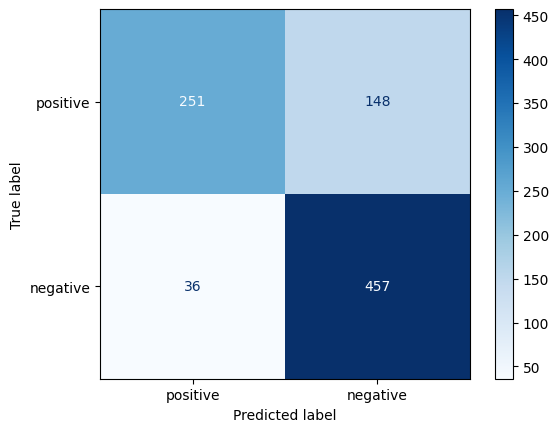

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['positive', 'negative']).plot(
    cmap=plt.cm.Blues)
plt.show()